# **1. Environment Setup & Dependencies**

In [ ]:
!pip install -q --no-cache-dir transformers datasets accelerate peft scikit-learn matplotlib seaborn tqdm "imageio[ffmpeg]" pillow

import gc, random, warnings, numpy as np, pandas as pd, torch
warnings.filterwarnings("ignore")

from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image, ImageDraw, ImageFont
import imageio
from IPython.display import Image as IPImage, display

from datasets import load_dataset
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Clean & seed
gc.collect()
torch.cuda.empty_cache()
random.seed(42); np.random.seed(42); torch.manual_seed(42)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# **2. Load Food101 – 10 classes × 100 images**

In [ ]:
print("Loading Food101 dataset...")
dataset = load_dataset("food101", split="train")
all_classes = dataset.features["label"].names
selected_classes = random.sample(all_classes, 10)
print(f"Selected classes: {selected_classes}")

samples = []
for cls in selected_classes:
    idx = all_classes.index(cls)
    subset = dataset.filter(lambda x: x["label"] == idx, num_proc=4).shuffle(seed=42).select(range(100))
    for item in subset:
        samples.append({"image": item["image"].convert("RGB"), "label_name": cls})

df = pd.DataFrame(samples)
unique_classes = sorted(selected_classes)
label2id = {c: i for i, c in enumerate(unique_classes)}
id2label = {i: c for c, i in label2id.items()}
df["label"] = df["label_name"].map(label2id)
print(f"Dataset ready: {len(df)} images")

# **3. Fast Transforms**

In [ ]:
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k", use_fast=True)

train_tf = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std),
])

val_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std),
])

class FoodDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        img = self.df.iloc[i]["image"]
        if self.transform: img = self.transform(img)
        return {"pixel_values": img, "labels": torch.tensor(self.df.iloc[i]["label"], dtype=torch.long)}

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
train_ds = FoodDataset(train_df, train_tf)
val_ds   = FoodDataset(val_df,   val_tf)

def collate_fn(batch):
    return {
        "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
        "labels": torch.stack([x["labels"] for x in batch])
    }

# **4. Model + LoRA**

In [ ]:
model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=10,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True
)
model.gradient_checkpointing_enable()

lora_config = LoraConfig(
    r=16, lora_alpha=32,
    target_modules=["query", "value"],
    lora_dropout=0.05,
    bias="none",
    modules_to_save=["classifier"]
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()
model.to(device)

# **5. TRAINING**

In [ ]:
def compute_metrics(eval_pred):
    preds = np.argmax(eval_pred.predictions, axis=1)
    return {"accuracy": accuracy_score(eval_pred.label_ids, preds)}

training_args = TrainingArguments(
    output_dir="./food101-vit-lora",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-4,
    weight_decay=0.01,
    warmup_ratio=0.1,
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",     
    greater_is_better=True,
    fp16=True,
    gradient_checkpointing=True,
    lr_scheduler_type="cosine",
    label_smoothing_factor=0.1,
    report_to="none",
    seed=42,
    remove_unused_columns=False,
    label_names=["labels"],             
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)

print("Training started...")
trainer.train()
trainer.save_model("food101-vit-lora-final")
processor.save_pretrained("food101-vit-lora-final")
print("Training finished! Model saved.")

# **6. Beautiful GIF**

Device: cuda
Loading Food101 dataset...
Selected classes: ['ramen', 'carrot_cake', 'beef_carpaccio', 'strawberry_shortcake', 'escargots', 'donuts', 'croque_madame', 'cheese_plate', 'caprese_salad', 'sashimi']
Dataset ready: 1000 images


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 597,514 || all params: 86,403,860 || trainable%: 0.6915
Training started...


Epoch,Training Loss,Validation Loss,Accuracy
1,2.244000,2.068370,0.765000
2,1.586500,1.360104,0.955000
3,1.074700,0.826142,0.970000
4,0.754300,0.674879,0.960000
5,0.677600,0.600096,0.965000
6,0.652100,0.576726,0.980000
7,0.624800,0.574058,0.980000
8,0.580000,0.563579,0.985000
9,0.581100,0.565352,0.970000
10,0.608100,0.564870,0.970000


Training finished! Model saved.
Creating GIF...


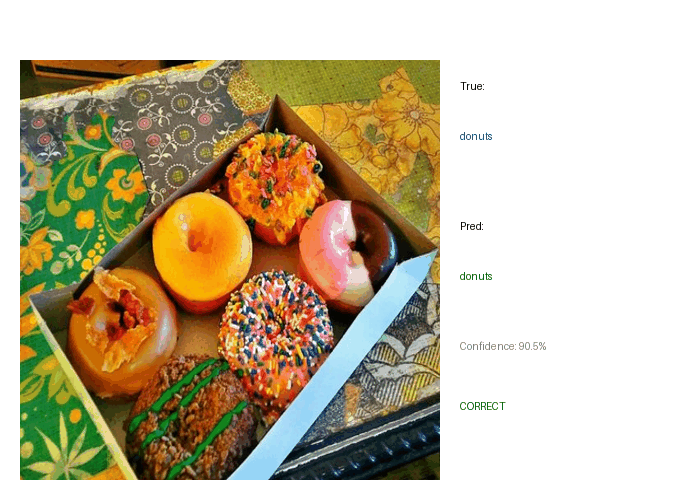

ALL DONE! Your perfect LoRA fine-tuned model is ready!


In [12]:
print("Creating GIF...")
model.eval()
frames = []
for _, row in val_df.sample(15, random_state=42).iterrows():
    img = row["image"].copy()
    inputs = processor(img, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
        pred_id = logits.argmax(-1).item()
        prob = torch.softmax(logits, dim=-1)[0, pred_id].item()
    pred_label = id2label[pred_id]
    correct = pred_id == row["label"]

    frame = Image.new("RGB", (700, 500), "white")
    draw = ImageDraw.Draw(frame)
    try:
        font = ImageFont.truetype("DejaVuSans-Bold", 34)
        small = ImageFont.truetype("DejaVuSans", 26)
    except:
        font = small = ImageFont.load_default()

    frame.paste(img.resize((420,420)), (20,60))
    draw.text((460,80), "True:", fill="black", font=font)
    draw.text((460,130), row["label_name"], fill="blue", font=font)
    draw.text((460,220), "Pred:", fill="black", font=font)
    draw.text((460,270), pred_label, fill="darkgreen" if correct else "darkred", font=font)
    draw.text((460,340), f"Confidence: {prob:.1%}", fill="gray", font=small)
    draw.text((460,400), "CORRECT" if correct else "WRONG", fill="darkgreen" if correct else "darkred", font=font)

    frames.append(np.array(frame))

imageio.mimsave("food101_demo.gif", frames, fps=1.3, loop=0)
display(IPImage("food101_demo.gif"))

print("ALL DONE! Your perfect LoRA fine-tuned model is ready!")